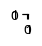

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import itertools
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

In [74]:
cedar=pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
cedar.query('len == len_icore_mut+2')[['Peptide','icore_mut','core_mut']]
df = cedar.query('HLA=="HLA-A0203" and len==9')[['Peptide','trueHLA_EL_rank']]
# df[[f'pos_{n}' for n in range(1, 10)]] = df['Peptide'].apply(lambda x: pd.Series(list(x)), result_type='expand')
df

,Peptide,trueHLA_EL_rank
266,CLMHHLAQA,0.0968
453,FILMGLPHV,0.1593
536,FLSIILDHL,0.1850
574,FMSTMDVLV,0.3540
1500,LMRDHMPPV,0.0817
2705,VLYLHITWV,0.0747


In [67]:
pd.DataFrame([x for x in 'FILMGLPHV'], index = range(1,10)).T

,1,2,3,4,5,6,7,8,9
0,F,I,L,M,G,L,P,H,V


In [75]:
df = pd.DataFrame([round(1/9,3) if x in ['G','P','H'] else 0 for x in AA_KEYS] , index=AA_KEYS).T
df['%Rank'] = 0.1593

In [77]:
pd.set_option('display.max_columns', 222)
df

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V,%Rank
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111,0.111,0.0,0.0,0.0,0.0,0.0,0.111,0.0,0.0,0.0,0.0,0.0,0.1593


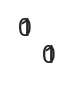

In [2]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [3]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

In [35]:
cedar_benchmark = pd.read_csv('../../benchmark/CEDAR_scored_withmodels_filtered_NODUPS.csv')
prime_benchmark = pd.read_csv('../../benchmark/PRIME_scored_withmodels_filtered_NODUPS.csv')
nepdb_benchmark = pd.read_csv('../../benchmark/NEPDB_scored_withmodels_filtered_NODUPS.csv')
list(filter(lambda x:'nna' in x.lower(), cedar_benchmark.columns))

['Unnamed: 0', 'nnalign_score', 'NNAlign_score_new']

In [78]:
scorecols = ['Base Model', 'Harmonic Model', #'NNAlign_score_new',
             'Axelf',
             'PRIME_score', 'foreignness_score', 'IEDB_score']

In [79]:
name={'Base Model':'Baseline', 'Harmonic Model':'ICERFIRE', #'NNAlign_score_new':'NNAlign',
      'Axelf':'AXEL-F', 'PRIME_score':'PRIME', 'foreignness_score':'Foreignness', 'IEDB_score':'IEDB-Calis'}

In [34]:
# cedar_benchmark.rename(columns={'NNAlign_score_new':'nnalign_score'},inplace=True)
list(filter(lambda x:'nna' in x.lower(), prime_benchmark.columns))

['Unnamed: 0', 'nnalign_score', 'NNAlign_score_new']

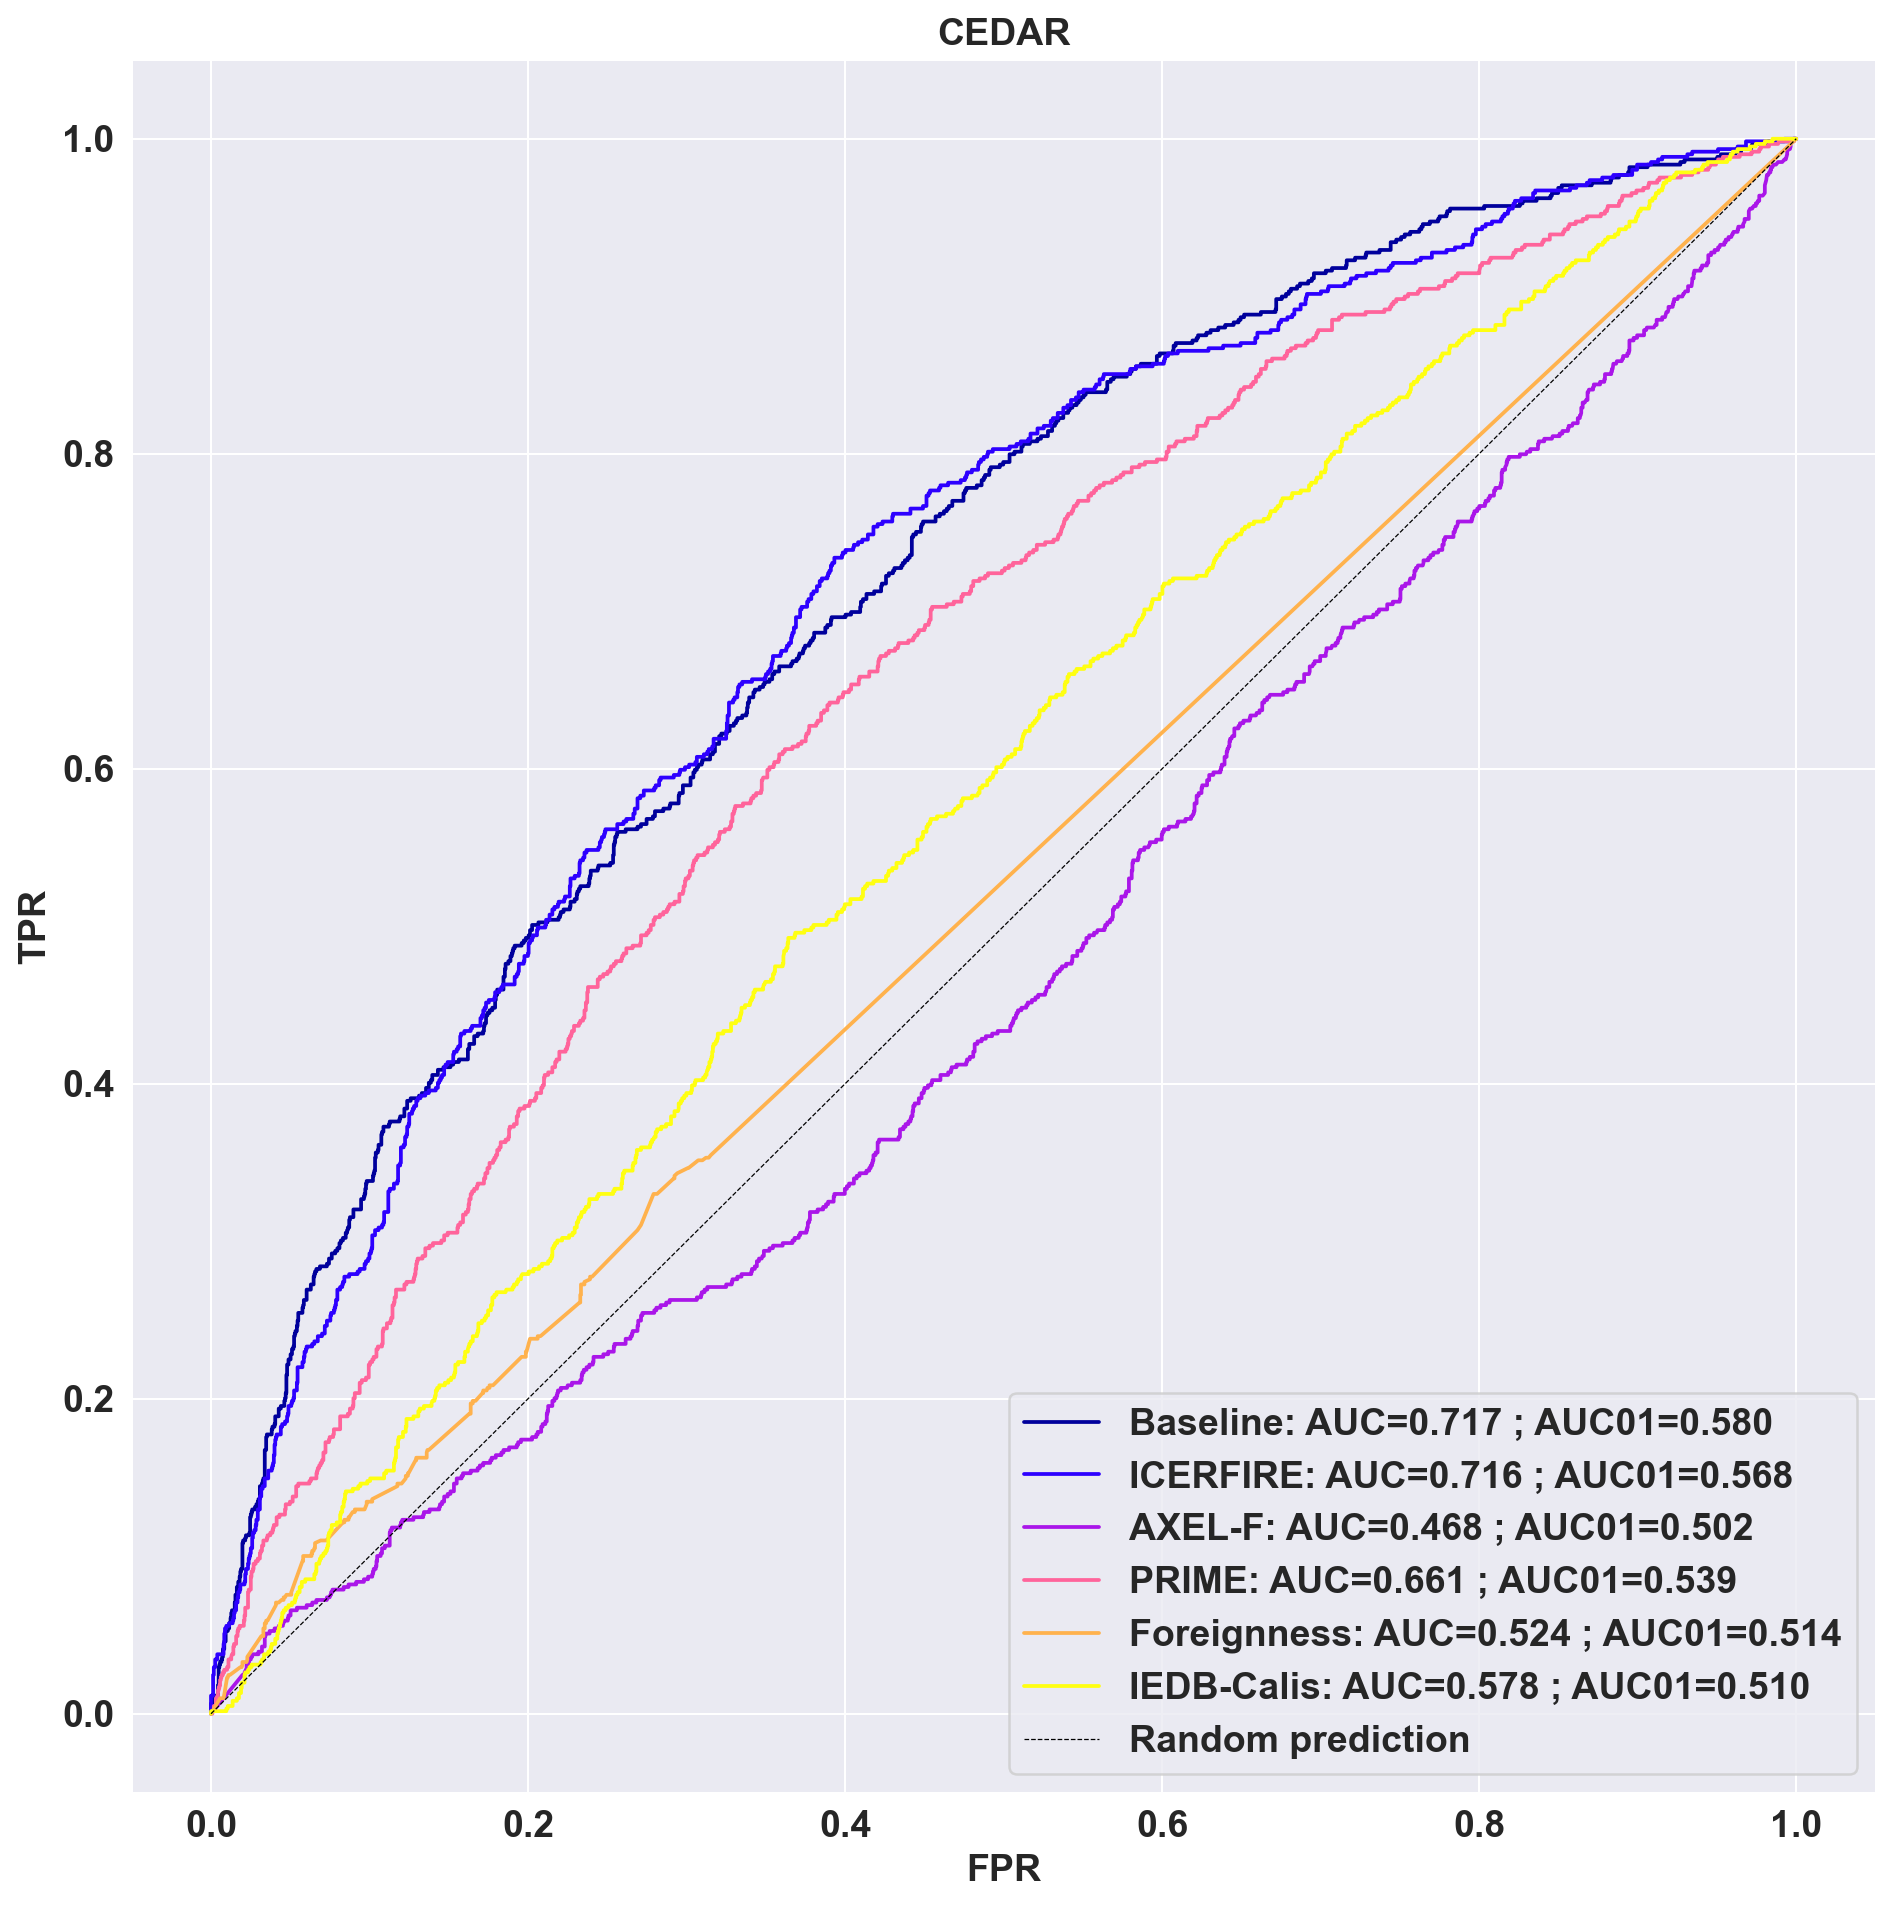

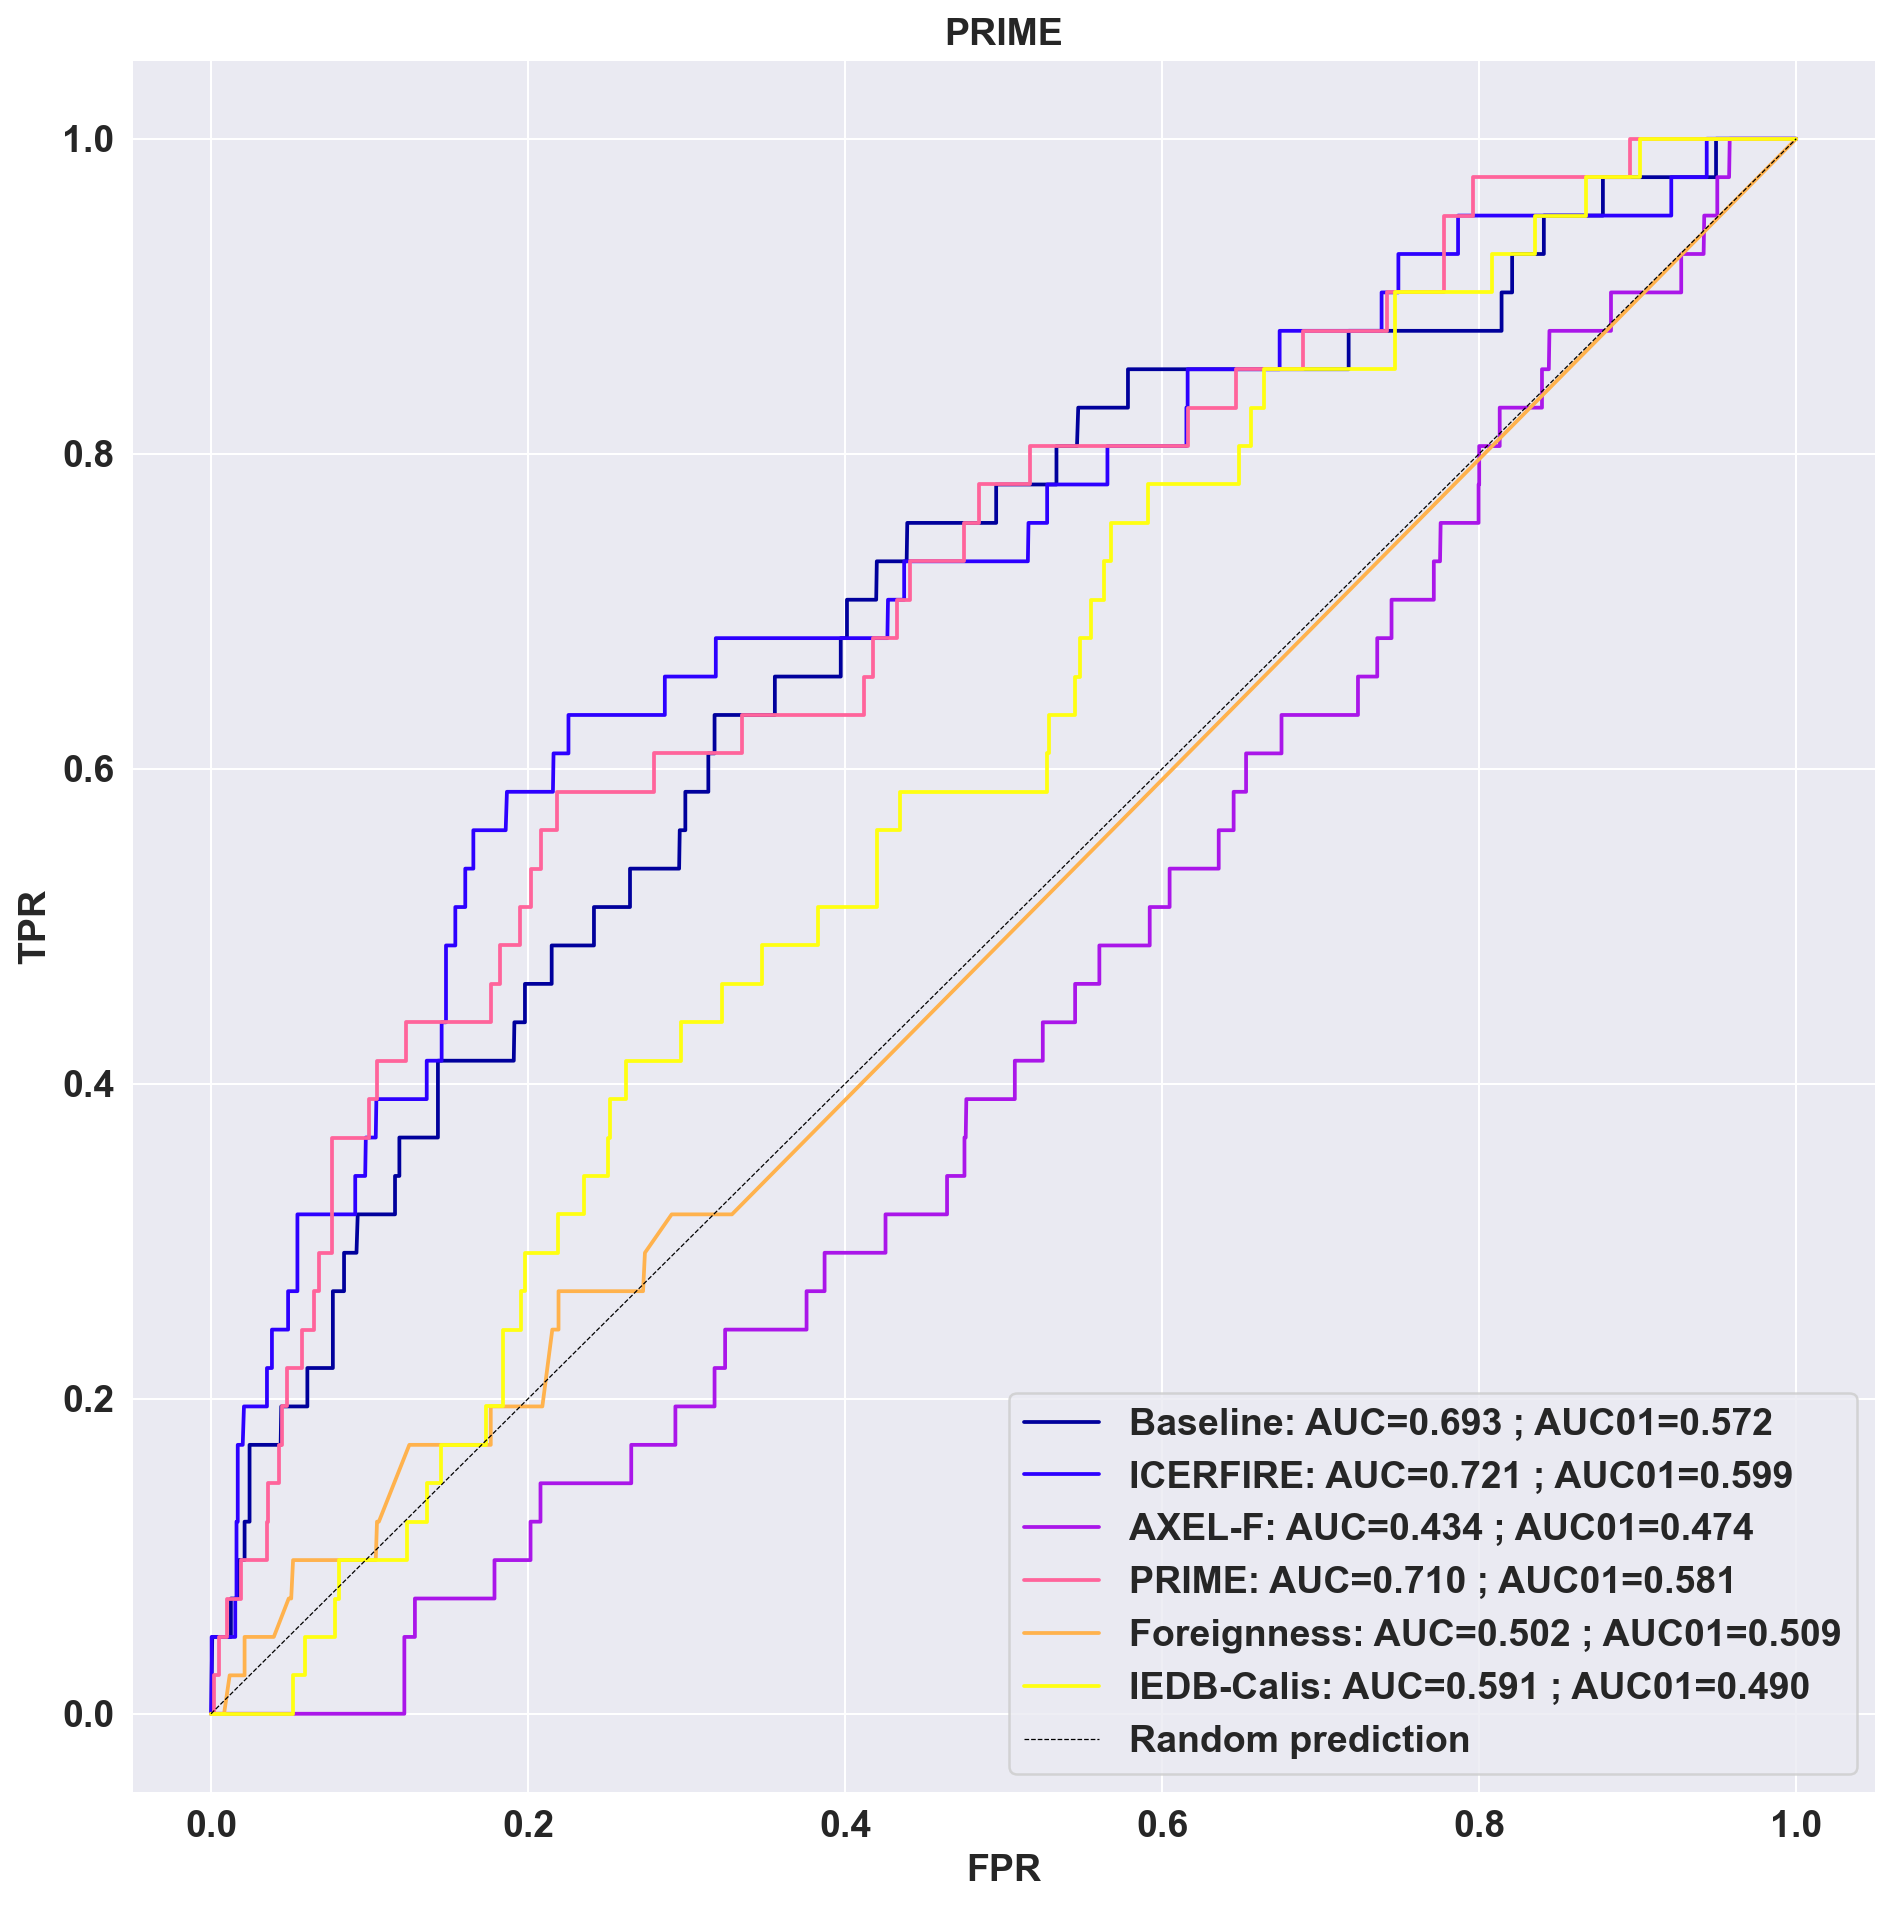

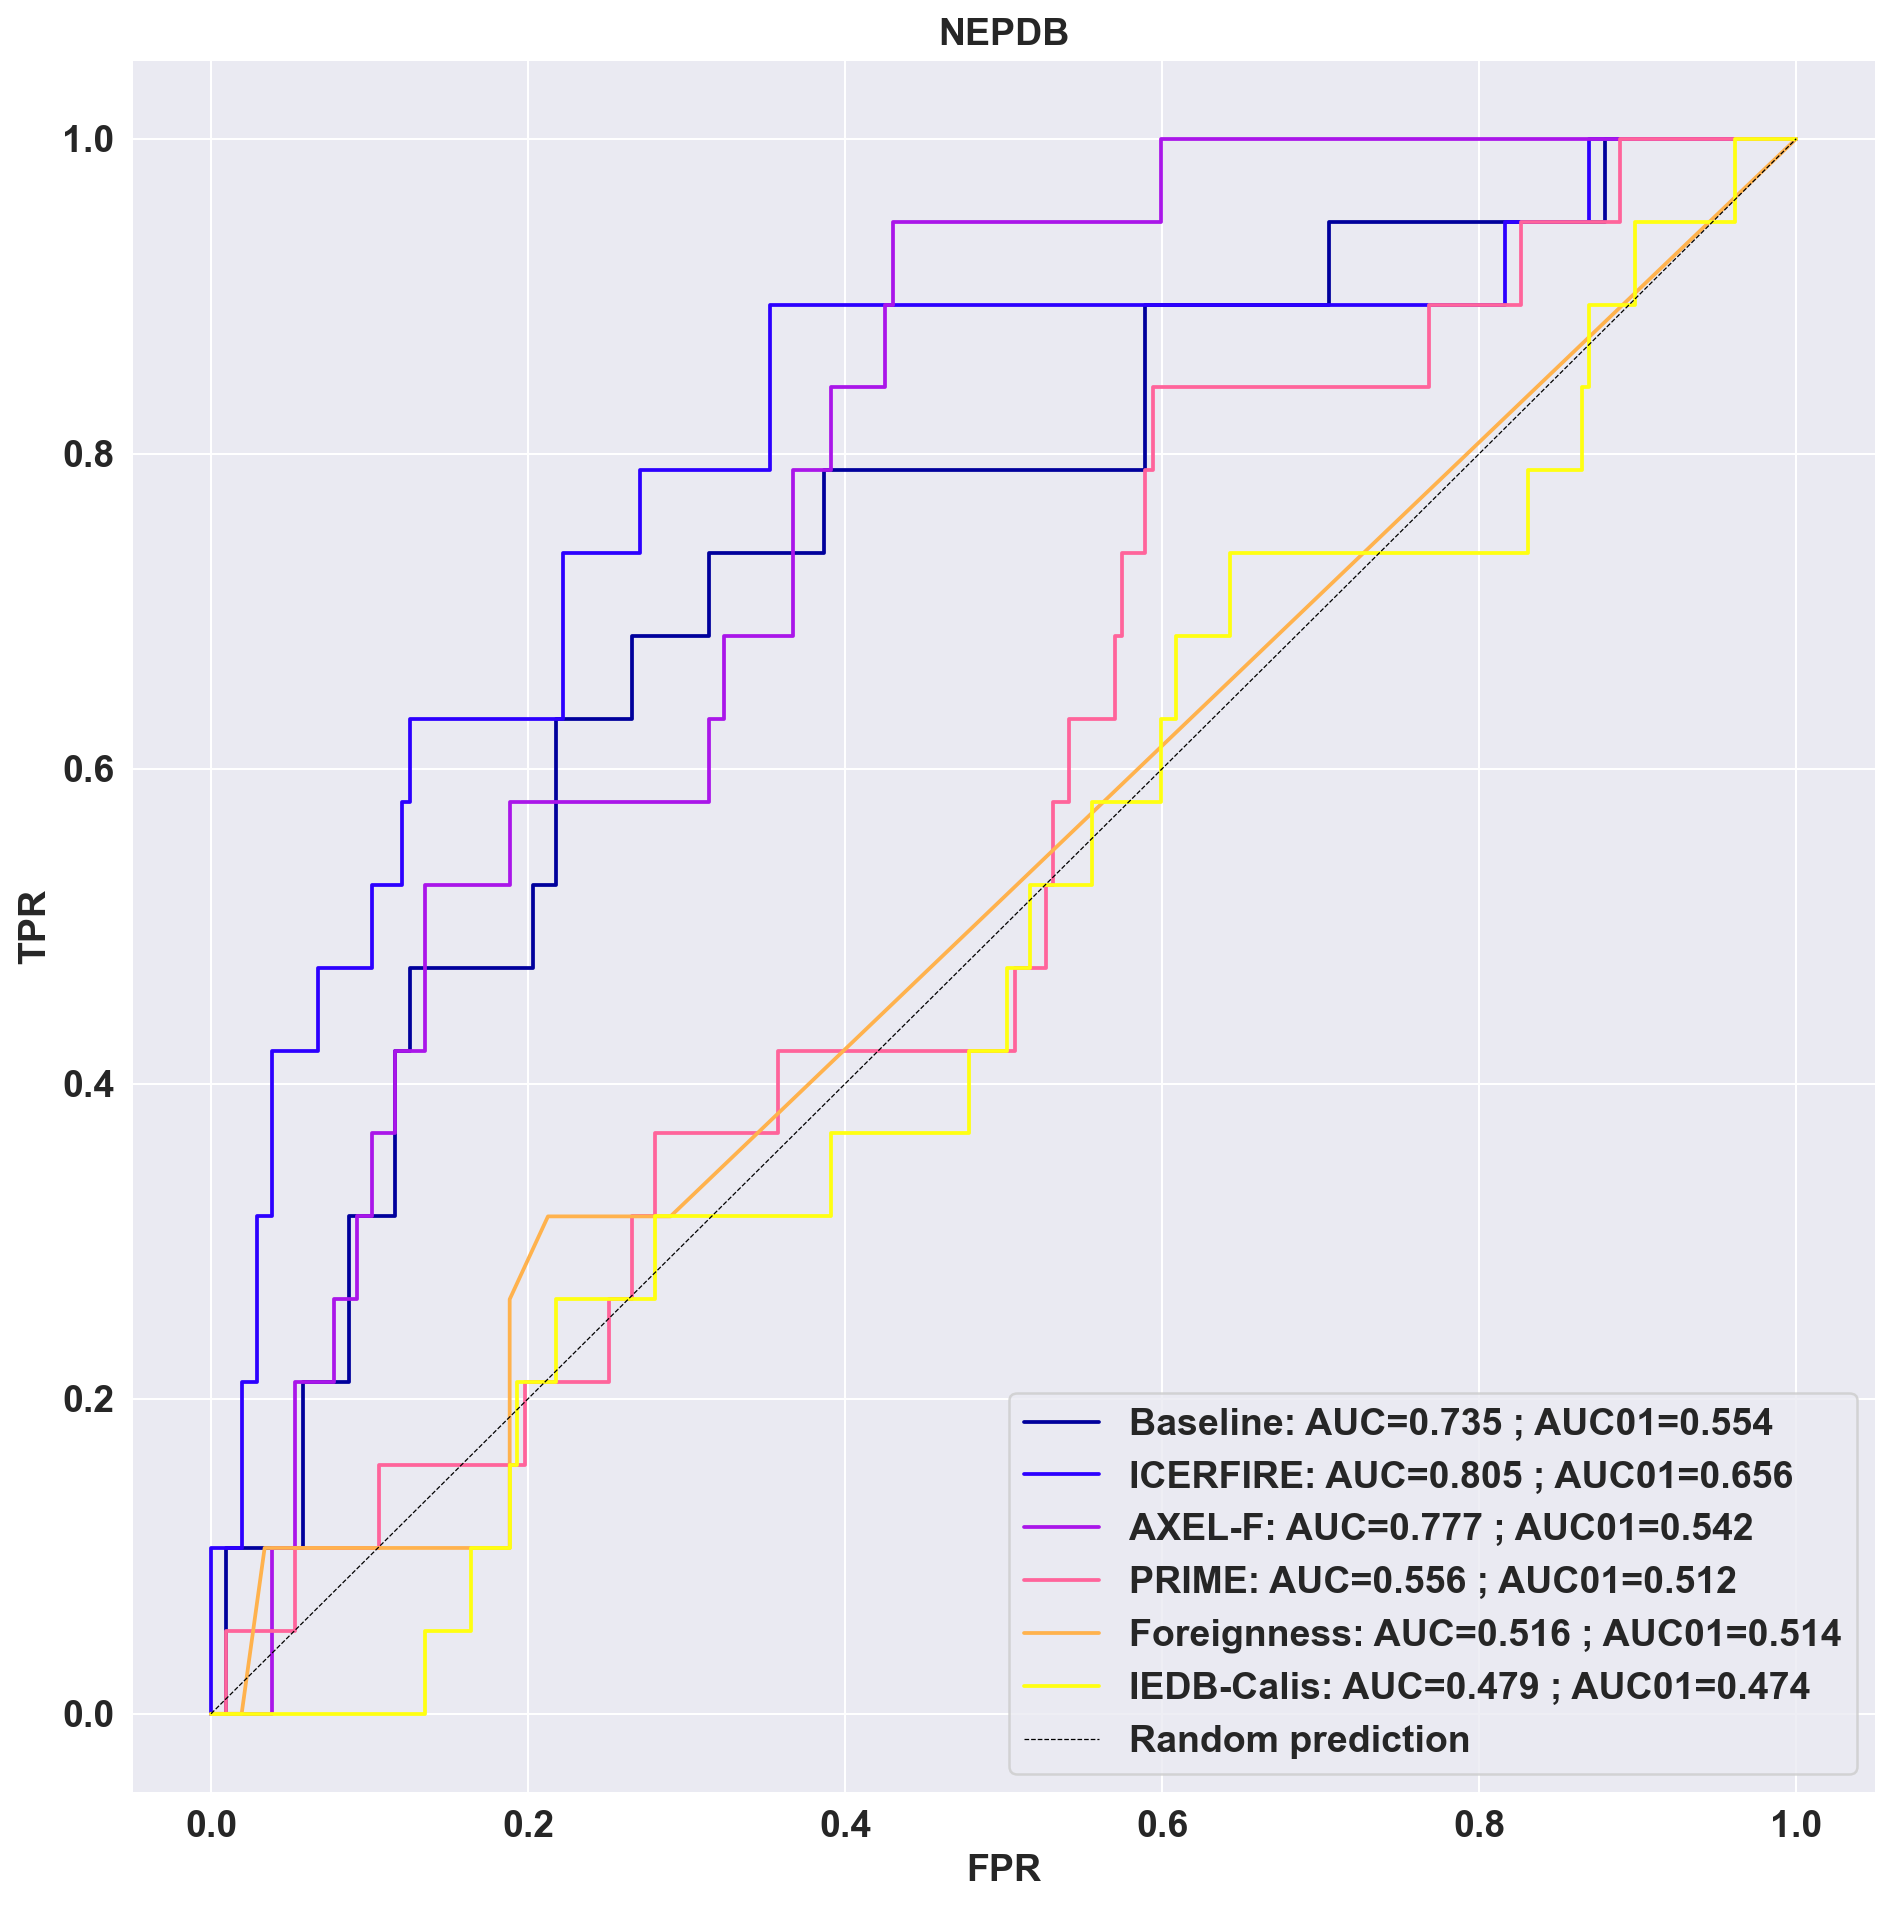

In [80]:
from src.utils import get_palette
for df, evalset in zip([cedar_benchmark, prime_benchmark, nepdb_benchmark], ['CEDAR', 'PRIME', 'NEPDB']):
    sns.set_palette(get_palette('gnuplot2', n_colors = len(scorecols)))
    f,a = plt.subplots(1,1, figsize=(12.5,12.5))
    for col in scorecols:
        fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', col, neg=False)
        sns.lineplot(x=fpr, y=tpr, label = f'{name[col]}: AUC={auc:.3f} ; AUC01={auc01:.3f}', estimator =None)
    a.set_title(evalset, fontsize=15, fontweight='semibold')
    a.plot([0,1],[0,1], label='Random prediction', c='k', lw=.5, ls='--')
    a.legend(loc='lower right', prop=dict(weight='semibold', size=15),
             title_fontproperties=dict(weight='semibold', size=15))
    a.set_xlabel('FPR', fontweight='semibold', fontsize=15)
    a.set_ylabel('TPR', fontweight='semibold', fontsize=15)
    a.set_xticklabels(a.get_xticklabels(), fontweight='semibold', fontsize=15)
    a.set_yticklabels(a.get_yticklabels(), fontweight='semibold', fontsize=15)

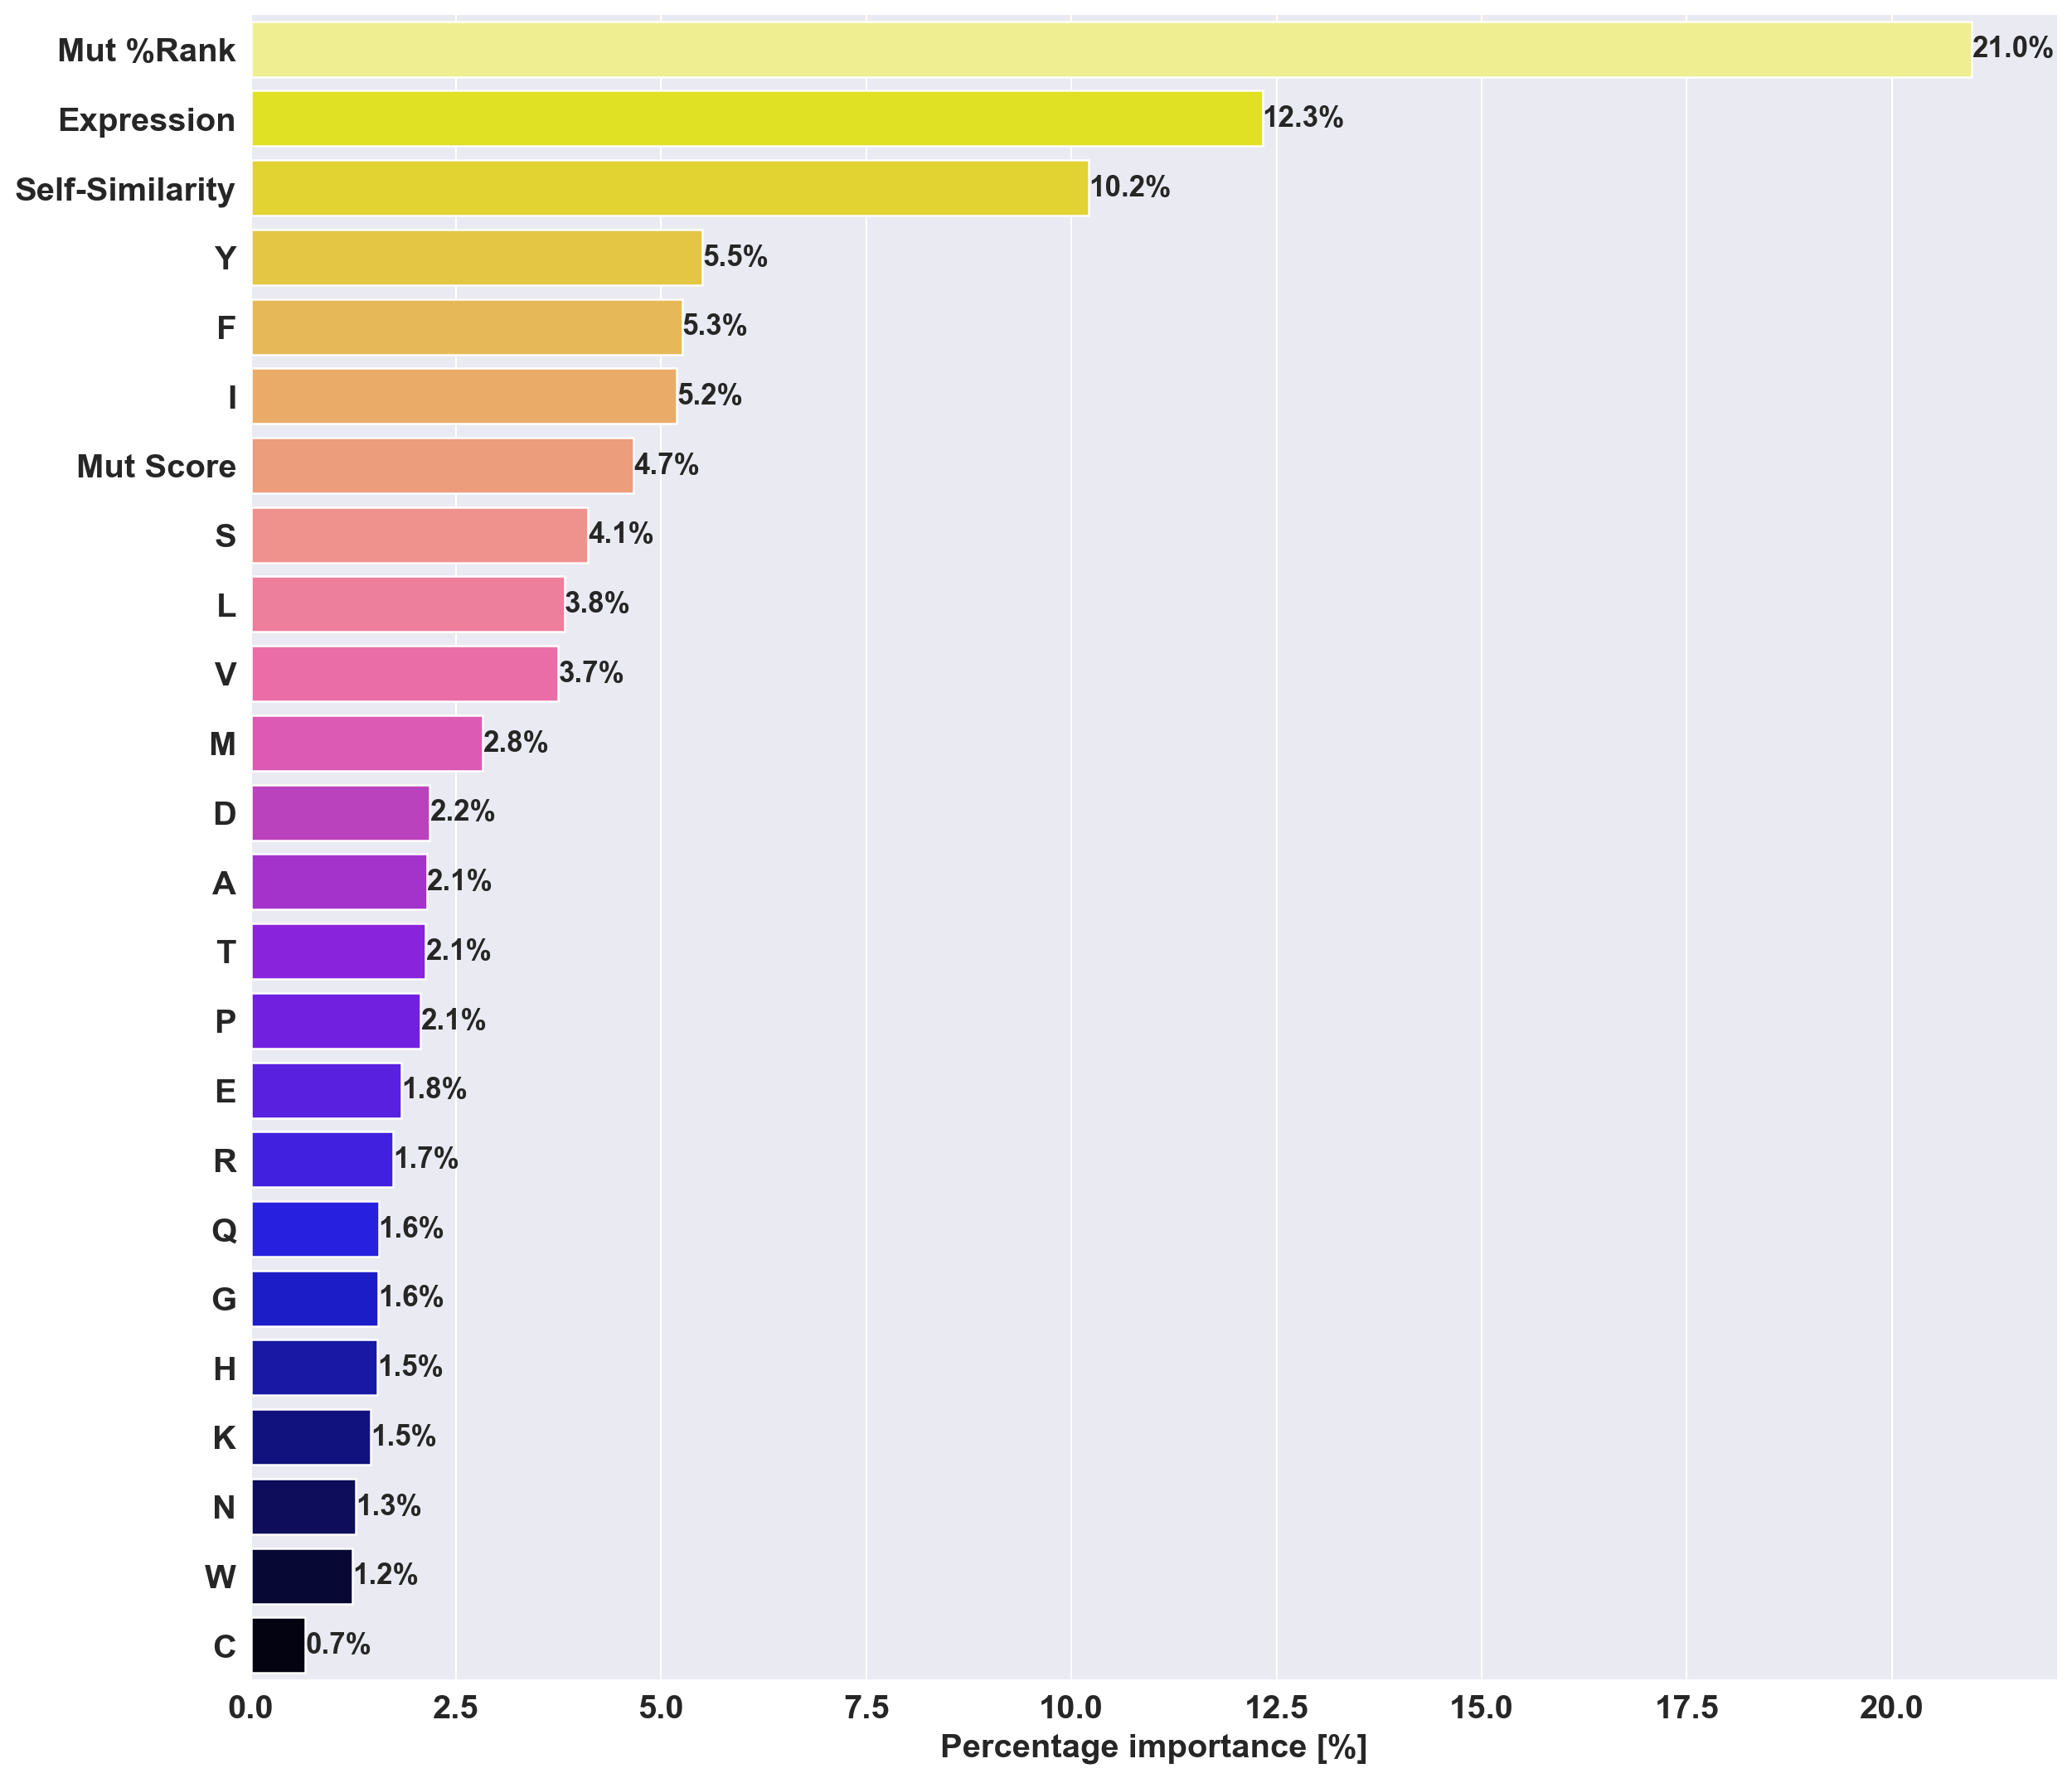

In [94]:
def get_fi(fn_dict, key, pdir='../output/230427_FINAL_ANALYSIS_ALL/raw/'):
    fn = f"featimps_{fn_dict[key]}.csv"
    return pd.read_csv(f'{pdir}{fn}')

def get_pred(evalset, fn_dict, key, pdir='../output/230427_FINAL_ANALYSIS_ALL/raw/'):
    fn = f"{evalset}_preds_{fn_dict[key]}.csv"
    print(pdir + fn,'\n')
    return pd.read_csv(f'{pdir}{fn}')

base_model = 'cedar_onehot_None_icore_mut_only_rank'
best_cedar = 'cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM'
best_prime = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM'
harmonic = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
compromise = 'cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
fn_dict = {'base_model':base_model, 'best_cedar':best_cedar, 'best_prime':best_prime, 'harmonic':harmonic, 'compromise':compromise}

fi_cedar = get_fi(fn_dict, 'best_cedar')
fi_prime = get_fi(fn_dict, 'best_prime')
fi_harmonic = get_fi(fn_dict, 'harmonic')
def rename(col):
    d = {'icore_boman':'Boman Index',
         'icore_blsm_mut_score':'Mut Score',
         'EL_rank_wt_aligned': 'WT %Rank',
         'rank': 'Mut %Rank',
         'foreignness_score': 'Foreignness',
         'Total_Gene_TPM' : 'Expression',
         'icore_dissimilarity_score':'Self-Similarity',
         'ratio_rank': 'Agretopicity'}
    if col in d.keys():
        return d[col]
    else:
        return col
from src.metrics import plot_feature_importance
# Remaking bigger
from src.metrics import plot_feature_importance
f,a = plt.subplots(1,1, figsize=(14,12), sharex=True)

plot_feature_importance(fi_harmonic.values.flatten(), 
                        list(map(rename,fi_harmonic.columns)), 
                        palette='gnuplot2_r', ax=a, title=None, 
                        label_number=True)
a.set_ylabel(None)
a.set_xlabel('Percentage importance [%]', fontsize=16, fontweight='semibold')
a.set_yticklabels(a.get_yticklabels(), fontsize=16, fontweight='semibold')
a.set_xticklabels(a.get_xticklabels(), fontsize=16, fontweight='semibold')

f.tight_layout(pad=1.005)
f.savefig('../../../meetings/slides/230622_SectionMeeting/FeatImps.png', bbox_inches='tight', dpi=600)
